## Imports and Parameters

Listing of imports and parameters required to successfully run the notebook.

In [1]:
# this tells Jupyter to embed matplotlib plots in the notebook
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import shapely as sp
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from shapely.geometry import Point
from shapely.geometry import Polygon

In [3]:
from IPython.display import display, HTML
import netCDF4
import pandas as pd
import numpy as np
import datetime as dt
import xarray as xr
import tarfile
import os
import geopandas as gpd
from copy import deepcopy

In [4]:
import pyodbc
import sqlalchemy

In [5]:
import DBA_DClimComp as DBAD

In [6]:
IN_DIR = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Recharge\Data\CMIP5'

In [7]:
NLDAS_GRID = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Recharge\Data\CM' \
             r'IP5\NLDAS_Grid_Reference\NLDAS_Grid_Reference.shp'

In [8]:
gpd_NLDAS = gpd.read_file( NLDAS_GRID )
inCRS = gpd_NLDAS.crs
inCRS

{'init': 'epsg:4326'}

In [9]:
AOI_SHP = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Re' \
          r'charge\GIS\Shapefiles\UTM14N\AOI.shp'
gpd_AOI = gpd.read_file( AOI_SHP )
utmCRS = gpd_AOI.crs
utmCRS

{'init': 'epsg:32614'}

In [10]:
PLT_CLIP = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Rec' \
           r'harge\GIS\Shapefiles\UTM14N\BigBoundary.shp'
gpd_SBnd = gpd.read_file( PLT_CLIP )
gpd_SBndLL = gpd_SBnd.to_crs( inCRS )

In [11]:
WORK_DIR = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Recharge\Data\CMIP5'

In [12]:
NO_DATA = -9999.0

## Definitions for Acquired Data Sets

Data were acquired in a specific order due to size limitations. Build a DataFrame here that encapsulates that order to use for extracting model results and building our database.

In [13]:
RequestID = range( 1, 16, 1 )
StartDates = [ dt.datetime( 1950, 1, 1 ), dt.datetime( 1981, 1, 1 ), dt.datetime( 2011, 1, 1 ),
               dt.datetime( 2041, 1, 1 ), dt.datetime( 2071, 1, 1 ), dt.datetime( 1950, 1, 1 ), 
               dt.datetime( 1981, 1, 1 ), dt.datetime( 2011, 1, 1 ), dt.datetime( 2041, 1, 1 ), 
               dt.datetime( 2071, 1, 1 ), dt.datetime( 1950, 1, 1 ), dt.datetime( 1981, 1, 1 ), 
               dt.datetime( 2011, 1, 1 ), dt.datetime( 2041, 1, 1 ), dt.datetime( 2071, 1, 1 ),
             ]
EndDates = [ dt.datetime( 1980, 12, 31 ), dt.datetime( 2010, 12, 31 ), dt.datetime( 2040, 12, 31 ),
               dt.datetime( 2070, 12, 31 ), dt.datetime( 2099, 12, 31 ), dt.datetime( 1980, 12, 31 ), 
               dt.datetime( 2010, 12, 31 ), dt.datetime( 2040, 12, 31 ), dt.datetime( 2070, 12, 31 ), 
               dt.datetime( 2099, 12, 31 ), dt.datetime( 1980, 12, 31 ), dt.datetime( 2010, 12, 31 ), 
               dt.datetime( 2040, 12, 31 ), dt.datetime( 2070, 12, 31 ), dt.datetime( 2099, 12, 31 ),
             ]
DataSetName = [ "LOCA-CMIP5 climate daily", #0
                "LOCA-CMIP5 climate daily", #1
                "LOCA-CMIP5 climate daily", #2
                "LOCA-CMIP5 climate daily", #3
                "LOCA-CMIP5 climate daily", #4
                "LOCA-CMIP5 climate daily", #5
                "LOCA-CMIP5 climate daily", #6
                "LOCA-CMIP5 climate daily", #7
                "LOCA-CMIP5 climate daily", #8
                "LOCA-CMIP5 climate daily", #9
                "BCCAv2-CMIP5 climate daily", #10
                "BCCAv2-CMIP5 climate daily", #11
                "BCCAv2-CMIP5 climate daily", #12
                "BCCAv2-CMIP5 climate daily", #13
                "BCCAv2-CMIP5 climate daily", #14
              ]
Emmissions_Scen = [ "RCP4.5", #0
                    "RCP4.5", #1
                    "RCP4.5", #2
                    "RCP4.5", #3
                    "RCP4.5", #4
                    "RCP8.5", #5
                    "RCP8.5", #6
                    "RCP8.5", #7
                    "RCP8.5", #8
                    "RCP8.5", #9
                    "RCP2.6, RCP4.5, RCP6.0, RCP8.5", #10
                    "RCP2.6, RCP4.5, RCP6.0, RCP8.5", #11
                    "RCP2.6, RCP4.5, RCP6.0, RCP8.5", #12
                    "RCP2.6, RCP4.5, RCP6.0, RCP8.5", #13
                    "RCP2.6, RCP4.5, RCP6.0, RCP8.5", #14
]
Labeler = [ "R1LOCA50t80", #0
            "R2LOCA81t10", #1
            "R3LOCA11t40", #2
            "R4LOCA41t70", #3
            "R5LOCA71t99", #4
            "R6LOCA50t80", #5
            "R7LOCA81t10", #6
            "R8LOCA11t40", #7
            "R9LOCA41t70", #8
            "R10LOCA71t99", #9
            "R11BCCA50t80", #10
            "R12BCCA81t10", #11
            "R13BCCA11t40", #12
            "R14BCCA41t70", #13
            "R15BCCA71t99", #14
           ]
DataDict = { "Start" : StartDates,
             "End" : EndDates,
             "Data Set" : DataSetName,
             "Scenario" : Emmissions_Scen,
             "Label" : Labeler
           }
ControlDF = pd.DataFrame( index=RequestID, data=DataDict )

In [14]:
display( HTML( ControlDF.to_html() ) )

,Start,End,Data Set,Scenario,Label
1,1950-01-01,1980-12-31,LOCA-CMIP5 climate daily,RCP4.5,R1LOCA50t80
2,1981-01-01,2010-12-31,LOCA-CMIP5 climate daily,RCP4.5,R2LOCA81t10
3,2011-01-01,2040-12-31,LOCA-CMIP5 climate daily,RCP4.5,R3LOCA11t40
4,2041-01-01,2070-12-31,LOCA-CMIP5 climate daily,RCP4.5,R4LOCA41t70
5,2071-01-01,2099-12-31,LOCA-CMIP5 climate daily,RCP4.5,R5LOCA71t99
6,1950-01-01,1980-12-31,LOCA-CMIP5 climate daily,RCP8.5,R6LOCA50t80
7,1981-01-01,2010-12-31,LOCA-CMIP5 climate daily,RCP8.5,R7LOCA81t10
8,2011-01-01,2040-12-31,LOCA-CMIP5 climate daily,RCP8.5,R8LOCA11t40
9,2041-01-01,2070-12-31,LOCA-CMIP5 climate daily,RCP8.5,R9LOCA41t70
10,2071-01-01,2099-12-31,LOCA-CMIP5 climate daily,RCP8.5,R10LOCA71t99


Also need to provide a dictionary of projects to use to identify which model produces which results

In [15]:
# Table 2. BCSD and BCCA CMIP5 Projection Ensembles
PNameDict = { "access1-0" : [ "Commonwealth Scientific and Industrial Research " \
                            "Organization and Bureau of Meteorology, Australia", 
                             ["RCP4.5", "RCP8.5"] ],
              "access1-3" : [ "Commonwealth Scientific and Industrial Research " \
                            "Organization and Bureau of Meteorology, Australia", 
                             ["RCP4.5", "RCP8.5"] ],
              "bcc-csm1-1" : [ "Beijing Climate Center, China Meteorological Administration", 
                               ["RCP2.6", "RCP4.5", "RCP6.0", "RCP8.5"] ],
              "bcc-csm1-1-m" : [ "Beijing Climate Center, China Meteorological Administration", 
                               ["RCP4.5", "RCP8.5"] ],
              "canesm2" : [ "Canadian Centre for Climate Modelling and Analysis", 
                               ["RCP2.6", "RCP4.5", "RCP8.5"] ],
              "ccsm4" : [ "National Center for Atmospheric Research", 
                                ["RCP2.6", "RCP4.5", "RCP6.0", "RCP8.5"] ],
              "cesm1-bgc" : [ "Community Earth System Model Contributors", 
                               ["RCP4.5", "RCP8.5"] ],
              "cesm1-cam5" : [ "Community Earth System Model Contributors", 
                               ["RCP2.6", "RCP4.5", "RCP6.0", "RCP8.5"] ],
              "cmcc-cm" : [ "Centro Euro-Mediterraneo per I Cambiamenti Climatici", 
                               ["RCP4.5", "RCP8.5"] ],
              "cmcc-cms" : [ "Centro Euro-Mediterraneo per I Cambiamenti Climatici", 
                               ["RCP4.5", "RCP8.5"] ],
              "cnrm-cm5" : [ "Centre National de Recherches Météorologiques/ Centre " \
                             "Européen de Recherche et Formation Avancée en Calcul Scientifique", 
                               ["RCP4.5", "RCP8.5"] ],
              "csiro-mk3-6-0" : [ "Commonwealth Scientific and Industrial Research Organization, " \
                                  "Queensland Climate Change Centre of Excellence", 
                                  ["RCP2.6", "RCP4.5", "RCP8.5"] ],
              "ec-earth" : [ "EC-Earth consortium, representing 22 academic institutions and " \
                             "meteorological services from 10 countries in Europe", 
                                  ["RCP2.6", "RCP4.5", "RCP8.5"] ],
              "fgoals-g2" : [ "Laboratory of Numerical Modeling for Atmospheric Sciences and " \
                              "Geophysical Fluid Dynamics, Institute of Atmospheric Physics, " \
                              "Chinese Academy of Sciences, and Center for Earth System Science, " \
                              "Tsinghua University", 
                              ["RCP2.6", "RCP4.5", "RCP8.5"] ],
              "gfdl-cm3" : [ "NOAA Geophysical Fluid Dynamics Laboratory", 
                               ["RCP2.6", "RCP4.5", "RCP6.0", "RCP8.5"] ],
              "gfdl-esm2g" : [ "NOAA Geophysical Fluid Dynamics Laboratory", 
                               ["RCP2.6", "RCP4.5", "RCP6.0", "RCP8.5"] ],
              "gfdl-esm2m" : [ "NOAA Geophysical Fluid Dynamics Laboratory", 
                               ["RCP2.6", "RCP4.5", "RCP6.0", "RCP8.5"] ],
              "giss-e2-h" : [ "NASA Goddard Institute for Space Studies", 
                               ["RCP4.5"] ],
              "giss-e2-r" : [ "NASA Goddard Institute for Space Studies", 
                               ["RCP2.6", "RCP4.5", "RCP6.0", "RCP8.5"] ],
              "hadgem2-ao" : [ "Met Office Hadley Centre (additional HadGEM2ES realizations " \
                               "contributed by Instituto Nacional de Pesquisas Espaciais)", 
                               ["RCP2.6", "RCP4.5", "RCP6.0", "RCP8.5"] ],
              "hadgem2-cc" : [ "Met Office Hadley Centre (additional HadGEM2ES realizations " \
                               "contributed by Instituto Nacional de Pesquisas Espaciais)", 
                               ["RCP4.5", "RCP8.5"] ],
              "hadgem2-es" : [ "Met Office Hadley Centre (additional HadGEM2ES realizations " \
                               "contributed by Instituto Nacional de Pesquisas Espaciais)", 
                               ["RCP2.6", "RCP4.5", "RCP6.0", "RCP8.5"] ],
              "inmcm4" : [ "Institute for Numerical Mathematics", 
                               ["RCP4.5", "RCP8.5"] ],
              "ipsl-cm5a-lr" : [ "Institut Pierre-Simon Laplace", 
                               ["RCP2.6", "RCP4.5", "RCP6.0", "RCP8.5"] ],
              "ipsl-cm5a-mr" : [ "Institut Pierre-Simon Laplace", 
                               ["RCP2.6", "RCP4.5", "RCP6.0", "RCP8.5"] ],
              "miroc-esm" : [ "Japan Agency for Marine-Earth Science and Technology, Atmosphere " \
                              "and Ocean Research Institute (The University of Tokyo), and " \
                              "National Institute for Environmental Studies", 
                               ["RCP2.6", "RCP4.5", "RCP6.0", "RCP8.5"] ],
              "miroc-esm-chem" : [ "Japan Agency for Marine-Earth Science and Technology, " \
                                   "Atmosphere and Ocean Research Institute (The University of " \
                                   "Tokyo), and National Institute for Environmental Studies", 
                                  ["RCP2.6", "RCP4.5", "RCP6.0", "RCP8.5"] ],
              "miroc5" : [ "Atmosphere and Ocean Research Institute (The University of Tokyo), " \
                           "National Institute for Environmental Studies, and Japan Agency for " \
                           "Marine-Earth Science and Technology", 
                           ["RCP2.6", "RCP4.5", "RCP6.0", "RCP8.5"] ],
              "mpi-esm-lr" : [ "Max-Planck-Institut für Meteorologie (Max Planck Institute for " \
                               "Meteorology)", 
                             ["RCP2.6", "RCP4.5", "RCP8.5"] ],
              "mpi-esm-mr" : [ "Max-Planck-Institut für Meteorologie (Max Planck Institute for " \
                               "Meteorology)", 
                             ["RCP2.6", "RCP4.5", "RCP8.5"] ],
              "mri-cgcm3" : [ "Meteorological Research Institute", 
                             ["RCP2.6", "RCP4.5", "RCP6.0", "RCP8.5"] ],
              "noresm1-m" : [ "Norwegian Climate Centre", 
                             ["RCP2.6", "RCP4.5", "RCP6.0", "RCP8.5"] ],
            }
PNameKeys = sorted( PNameDict.keys() )

## Develop an Understanding of Acquired Data Sets

The first thing to do is to look at the tar files and see what we have.

In [16]:
InDir1 = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Recharge\Data\CM' \
         r'IP5\R1LOCA50t80'

In [17]:
F_loca5_1x1 = 'loca5_1x1.tar.gz'

In [18]:
InTAR = os.path.normpath( os.path.join( InDir1, F_loca5_1x1 ) )

In [19]:
cfTAR = tarfile.open( InTAR, "r:gz" )

In [20]:
for tarinfo in cfTAR:
    print(tarinfo.name, "is", tarinfo.size, "bytes in size and is ", end="")
    if tarinfo.isreg():
        print("a regular file.")
    elif tarinfo.isdir():
        print("a directory.")
    else:
        print("something else.")

loca5_1x1 is 0 bytes in size and is a directory.
loca5_1x1/Extraction_tasmax.nc is 5908732 bytes in size and is a regular file.
loca5_1x1/MetaData.txt is 824 bytes in size and is a regular file.
loca5_1x1/Extraction_tasmin.nc is 5932352 bytes in size and is a regular file.
loca5_1x1/Extraction_pr.nc is 5906888 bytes in size and is a regular file.
loca5_1x1/Projections5.txt is 585 bytes in size and is a regular file.
loca5_1x1/Notes.txt is 10368 bytes in size and is a regular file.


Downscaled CMIP5 model results for the study area where obtained from:

[Downscaled CMIP3 and CMIP5 Climate and Hydrology Projections](https://gdo-dcp.ucllnl.org/downscaled_cmip_projections/dcpInterface.html)

Daily downscaled values for precipitation and minimum and maximum air temperature were obtained for the LOCA downscaling methodology. Two scenarios were available:

- RCP4.5 (32 different models)
- RCP8.5 (32 different models)

These results included the following categories of which the **loca** ones are model results and **obs** are actual observations.

- 1_16obs: 1/16 degree observed (Livneh 2015) data
- loca5: 1/16 degree bias-corrected & downscaled cmip5 GCM projections (daily)
- loca5_1x1: 1 degree bias-corrected & downscaled cmip5 GCM projections (daily); These are bias-corrected on the native GCM grid, then downscaled with the LOCA method to 1 degree

The full time series could not be downloaded at one time so that the complete record was broken into the following intervals:

1. 1/1950 - 12/1980
2. 1/1981 - 12/2010
3. 1/2011 - 12/2040
4. 1/2041 - 12/2070
5. 1/2071 - 12/2099

For our purposes, want to look at **loca5** for model projections and **1_16obs** for comparison data.

There are also Bias-Corrected and downscaled CMIP5 GCM projections. These are the BCCA collection. For the BCCA collection want to pull out the 1/8 degree bias-corrected & downscaled CMIP5 GCM projections (daily) which are in the **bcca5** folder. The corresponding data are in the **1_8obs** folder. 

### Some Globals for All Extractions

In [21]:
BCCA5_FOLDER = "bcca5"
LOCA5_FOLDER = "loca5"
L5OBS_FOLDER = "1_16obs"
B5OBS_FOLDER = "1_8obs"

In [22]:
DATA_ROOT = "Extraction"
PRECIP_ROOT = "pr"
TMAX_ROOT = "tasmax"
TMIN_ROOT = "tasmin"
NC_EXT = "nc"

In [23]:
MODS_FILE = "Projections5.txt"

### Extract an Example for Testing

Extract one data set as an example to use for testing. Use this example to formulate a loop so that know what we have and to ensure that get model results out in the correct format.

In [24]:
iI = 0
CurDir = ControlDF.at[(iI + 1), 'Label']

In [25]:
pFile = "%s_%s.%s" % (DATA_ROOT, PRECIP_ROOT, NC_EXT)
tmxFile = "%s_%s.%s" % (DATA_ROOT, TMAX_ROOT, NC_EXT)
tmnFile = "%s_%s.%s" % (DATA_ROOT, TMIN_ROOT, NC_EXT)

In [26]:
LocaFile = os.path.normpath( os.path.join( WORK_DIR, CurDir, LOCA5_FOLDER, pFile ) )
#tmaxFile = os.path.normpath( os.path.join( WORK_DIR, CurDir, LOCA5_FOLDER, tmxFile ) )
#tminFile = os.path.normpath( os.path.join( WORK_DIR, CurDir, LOCA5_FOLDER, tmnFile ) )

In [27]:
display( HTML( gpd_NLDAS.head().to_html() ) )

,CENTERX,CENTERY,NLDAS_X,NLDAS_Y,NLDAS_ID,geometry
0,-124.9375,25.0625,1,1,x1y1,"POLYGON ((-124.875 25, -124.9999999999999 25, ..."
1,-124.8125,25.0625,2,1,x2y1,"POLYGON ((-124.75 25, -124.875 25, -124.875 25..."
2,-124.6875,25.0625,3,1,x3y1,"POLYGON ((-124.6249999999999 25, -124.75 25, -..."
3,-124.5625,25.0625,4,1,x4y1,"POLYGON ((-124.5 25, -124.6249999999999 25, -1..."
4,-124.4375,25.0625,5,1,x5y1,"POLYGON ((-124.375 25, -124.5 25, -124.5 25.12..."


<IPython.core.display.Javascript object>


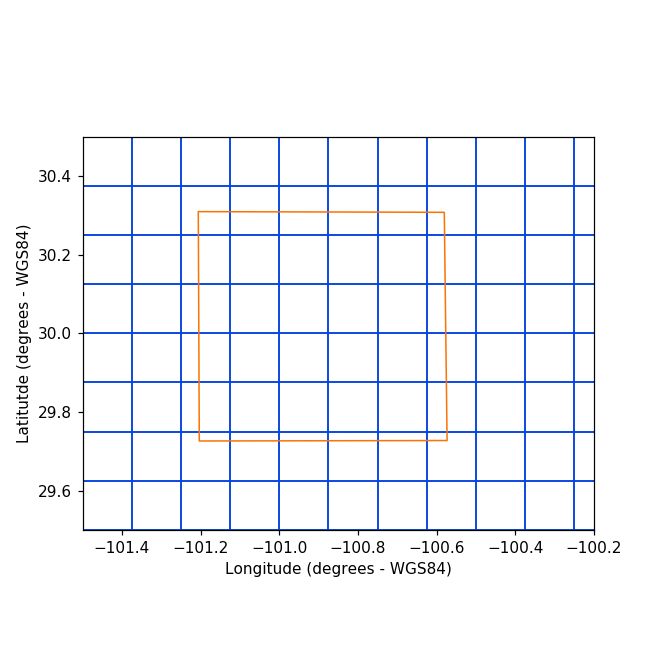

Text(0, 0.5, 'Latitutde (degrees - WGS84)')

In [28]:
Fig1 = plt.figure()
Fig1.set_size_inches(6.0, 6.0)
ax11 = Fig1.add_subplot(111)
gpd_NLDAS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:blue' )
gpd_SBndLL.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange' )
ax11.set_xlim( ( -101.5, -100.2 ) )
ax11.set_ylim( ( 29.5, 30.5 ) )
ax11.set_xlabel('Longitude (degrees - WGS84)')
ax11.set_ylabel('Latitutde (degrees - WGS84)')
#ax11.yaxis.set_major_formatter( matplotlib.ticker.StrMethodFormatter( "{x:,.0f}" ) )
#ax11.xaxis.set_major_formatter( matplotlib.ticker.StrMethodFormatter( "{x:,.0f}" ) )

Now intersect the NLDAS grid with our outer boundary so that we can project it to WGS84 UTM Zone 14N for other plotting

In [29]:
gpd_smNLDAS = gpd.overlay( gpd_SBndLL, gpd_NLDAS, how='intersection' )
gpd_smNLDASU = gpd_smNLDAS.to_crs( utmCRS )

<IPython.core.display.Javascript object>


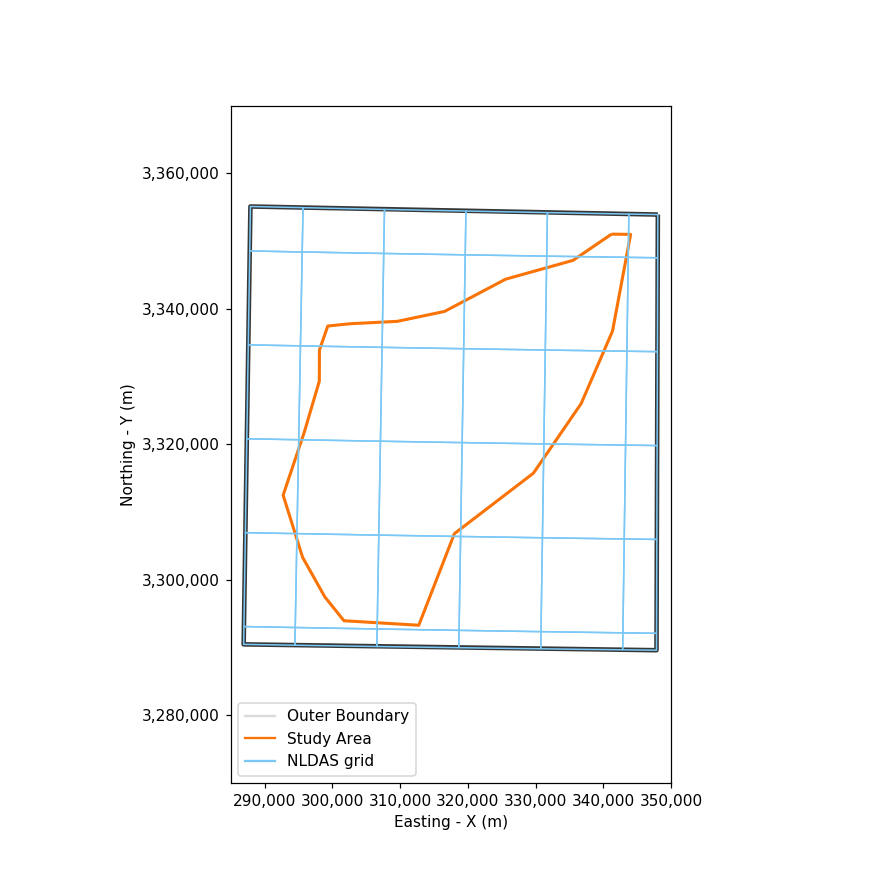

In [30]:
Fig1 = plt.figure()
Fig1.set_size_inches(8.0, 8.0)
ax11 = Fig1.add_subplot(111)
gpd_AOI.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, label="AOI" )
gpd_SBnd.plot( ax=ax11, facecolor='none', edgecolor='xkcd:dark grey', linewidth=3, label="Outer Bnd")
gpd_smNLDASU.plot( ax=ax11, facecolor='none', edgecolor='xkcd:lightblue', label="NLDAS" )
ob = Line2D( [0], [0], linestyle='-', color='xkcd:light grey' )
aoi = Line2D( [0], [0], linestyle='-', color='xkcd:orange' )
nlda = Line2D( [0], [0], linestyle='-', color='xkcd:lightblue' )
ax11.legend( (ob, aoi, nlda), ('Outer Boundary', 'Study Area', 'NLDAS grid'),
             loc='lower left')
ax11.set_xlim( ( 285000, 350000 ) )
ax11.set_ylim( ( 3270000, 3370000 ) )
ax11.set_xlabel('Easting - X (m)')
ax11.set_ylabel('Northing - Y (m)')
ax11.yaxis.set_major_formatter( matplotlib.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( matplotlib.ticker.StrMethodFormatter( "{x:,.0f}" ) )

In [31]:
# LocaFile
testLC = xr.open_dataset( LocaFile )

In [ ]:
#testLC

In [ ]:
#testTMX = xr.open_dataset( tmaxFile )

In [ ]:
#testTMX

In [ ]:
#testTMX.close()

In [ ]:
#testTMN = xr.open_dataset( tminFile )

In [ ]:
#testTMN

In [ ]:
#testTMN.close()

In [32]:
da = testLC['pr']

In [33]:
#da

In [34]:
cTO = da.time
type(cTO)

xarray.core.dataarray.DataArray

In [35]:
cTS = cTO.data
cTS.shape

(11323,)

In [36]:
cTS[:5]

array(['1950-01-01T12:00:00.000000000', '1950-01-02T12:00:00.000000000',
       '1950-01-03T12:00:00.000000000', '1950-01-04T12:00:00.000000000',
       '1950-01-05T12:00:00.000000000'], dtype='datetime64[ns]')

In [37]:
pd.to_datetime( cTS, utc=True )

DatetimeIndex(['1950-01-01 12:00:00+00:00', '1950-01-02 12:00:00+00:00',
               '1950-01-03 12:00:00+00:00', '1950-01-04 12:00:00+00:00',
               '1950-01-05 12:00:00+00:00', '1950-01-06 12:00:00+00:00',
               '1950-01-07 12:00:00+00:00', '1950-01-08 12:00:00+00:00',
               '1950-01-09 12:00:00+00:00', '1950-01-10 12:00:00+00:00',
               ...
               '1980-12-22 12:00:00+00:00', '1980-12-23 12:00:00+00:00',
               '1980-12-24 12:00:00+00:00', '1980-12-25 12:00:00+00:00',
               '1980-12-26 12:00:00+00:00', '1980-12-27 12:00:00+00:00',
               '1980-12-28 12:00:00+00:00', '1980-12-29 12:00:00+00:00',
               '1980-12-30 12:00:00+00:00', '1980-12-31 12:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=11323, freq=None)

In [38]:
cLon = da.lon.data
cLon.shape

(14,)

In [39]:
cLon

array([258.65625, 258.71875, 258.78125, 258.84375, 258.90625, 258.96875,
       259.03125, 259.09375, 259.15625, 259.21875, 259.28125, 259.34375,
       259.40625, 259.46875])

In [40]:
cLon = cLon - 360.0
cLon

array([-101.34375, -101.28125, -101.21875, -101.15625, -101.09375,
       -101.03125, -100.96875, -100.90625, -100.84375, -100.78125,
       -100.71875, -100.65625, -100.59375, -100.53125])

In [41]:
cLatt = da.lat.data
cLatt

array([29.65625, 29.71875, 29.78125, 29.84375, 29.90625, 29.96875,
       30.03125, 30.09375, 30.15625, 30.21875, 30.28125, 30.34375])

### Create the Grid Metadata

Go through our dataset and make our points. Note that the LOCA method has 1/16 of a degree and the BCCA method has 1/8 of a degree so these two have different grids and points. Will need to do for each grid type.

In [42]:
tPrecip = da.data
tPrecip.shape

(32, 11323, 12, 14)

In [43]:
NumRows = len( cLatt )
NumCols = len( cLon )
NumRows, NumCols

(12, 14)

In [44]:
NumNodes = NumRows * NumCols

In [45]:
lPointList = list()
RowList = list()
ColList = list()
LonList = list()
LatList = list()
DataList = list()
for iI in range(NumRows):
    for jJ in range(NumCols):
        cPnt = Point( cLon[jJ], cLatt[iI] )
        lPointList.append( cPnt )
        RowList.append( iI )
        ColList.append( jJ )
        LonList.append( cLon[jJ] )
        LatList.append( cLatt[iI] )
        DataList.append( tPrecip[0, 0, iI, jJ] )
    # end of outer for
# end of inner for

In [46]:
LocalID = range( 1, NumNodes + 1, 1 )

In [47]:
DSType = [ DBAD.DS_LOCA for x in range(NumNodes) ]
DSRes = [ "1/16th degree" for x in range(NumNodes) ]

In [48]:
DataDict = { DBAD.FIELDN_ROW : RowList,
             DBAD.FIELDN_COL : ColList,
             DBAD.FIELDN_LON : LonList,
             DBAD.FIELDN_LAT : LatList,
             DBAD.FIELDN_DSMETHOD : DSType,
             DBAD.FIELDN_DSRES : DSRes,
           }
updMetaDF = pd.DataFrame( index=LocalID, data=DataDict )

In [49]:
display( HTML( updMetaDF.head().to_html() ) )

,Row,Col,Longitude,Lattitude,DS_Method,DS_Resolution
1,0,0,-101.34375,29.65625,LOCA,1/16th degree
2,0,1,-101.28125,29.65625,LOCA,1/16th degree
3,0,2,-101.21875,29.65625,LOCA,1/16th degree
4,0,3,-101.15625,29.65625,LOCA,1/16th degree
5,0,4,-101.09375,29.65625,LOCA,1/16th degree


In [50]:
copyMetaDF = updMetaDF.copy()

In [51]:
gpd_tPre = gpd.GeoDataFrame( copyMetaDF, geometry=lPointList )
gpd_tPre.crs = inCRS
gpd_tPreU = gpd_tPre.to_crs( utmCRS )

In [52]:
PtX = lambda Pt: Pt.x
PtY = lambda Pt: Pt.y

In [53]:
gpd_tPreU[DBAD.FIELDN_X] = gpd_tPreU.apply( lambda row: PtX( row['geometry'] ), axis=1 )
gpd_tPreU[DBAD.FIELDN_Y] = gpd_tPreU.apply( lambda row: PtY( row['geometry'] ), axis=1 )

In [54]:
display( HTML( gpd_tPreU.head().to_html() ) )

,Row,Col,Longitude,Lattitude,DS_Method,DS_Resolution,geometry,utm_x,utm_y
1,0,0,-101.34375,29.65625,LOCA,1/16th degree,POINT (273143.2207769858 3282992.683303372),273143.220777,3.282993e+06
2,0,1,-101.28125,29.65625,LOCA,1/16th degree,POINT (279194.4006704497 3282871.77297417),279194.400670,3.282872e+06
3,0,2,-101.21875,29.65625,LOCA,1/16th degree,POINT (285245.4455121707 3282754.136565418),285245.445512,3.282754e+06
4,0,3,-101.15625,29.65625,LOCA,1/16th degree,POINT (291296.359000608 3282639.773577565),291296.359001,3.282640e+06
5,0,4,-101.09375,29.65625,LOCA,1/16th degree,POINT (297347.1448343502 3282528.683524988),297347.144834,3.282529e+06


In [55]:
updMetaDF[DBAD.FIELDN_X] = np.array( gpd_tPreU[DBAD.FIELDN_X], dtype=np.float32 )
updMetaDF[DBAD.FIELDN_Y] = np.array( gpd_tPreU[DBAD.FIELDN_Y], dtype=np.float32 )

In [56]:
display( HTML( updMetaDF.head().to_html() ) )

,Row,Col,Longitude,Lattitude,DS_Method,DS_Resolution,utm_x,utm_y
1,0,0,-101.34375,29.65625,LOCA,1/16th degree,273143.21875,3282992.75
2,0,1,-101.28125,29.65625,LOCA,1/16th degree,279194.40625,3282871.75
3,0,2,-101.21875,29.65625,LOCA,1/16th degree,285245.43750,3282754.25
4,0,3,-101.15625,29.65625,LOCA,1/16th degree,291296.34375,3282639.75
5,0,4,-101.09375,29.65625,LOCA,1/16th degree,297347.15625,3282528.75


<IPython.core.display.Javascript object>


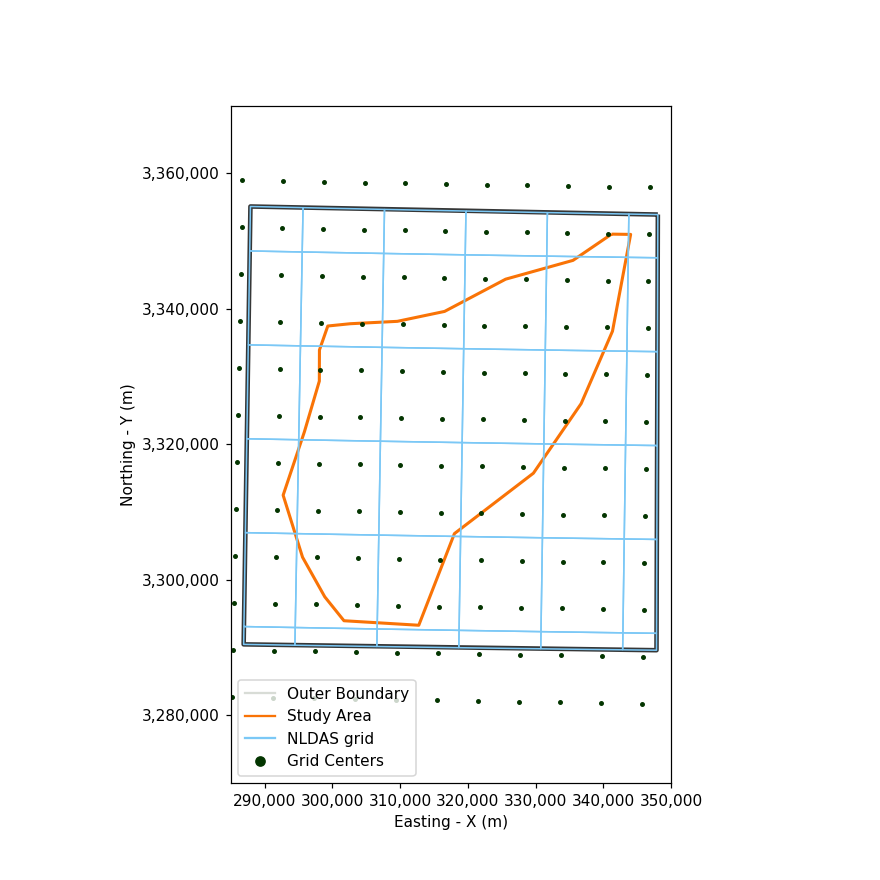

In [57]:
Fig1 = plt.figure()
Fig1.set_size_inches(8.0, 8.0)
ax11 = Fig1.add_subplot(111)
gpd_AOI.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, label="AOI" )
gpd_SBnd.plot( ax=ax11, facecolor='none', edgecolor='xkcd:dark grey', linewidth=3, label="Outer Bnd")
gpd_smNLDASU.plot( ax=ax11, facecolor='none', edgecolor='xkcd:lightblue', label="NLDAS" )
gpd_tPreU.plot( ax=ax11, marker='o', color='xkcd:dark green', markersize=5 )
ob = Line2D( [0], [0], linestyle='-', color='xkcd:light grey' )
aoi = Line2D( [0], [0], linestyle='-', color='xkcd:orange' )
nlda = Line2D( [0], [0], linestyle='-', color='xkcd:lightblue' )
ncent = Line2D( [], [], linestyle='None', marker='o', color='xkcd:dark green')
ax11.legend( (ob, aoi, nlda, ncent), ('Outer Boundary', 'Study Area', 'NLDAS grid', 'Grid Centers'),
             loc='lower left')
ax11.set_xlim( ( 285000, 350000 ) )
ax11.set_ylim( ( 3270000, 3370000 ) )
ax11.set_xlabel('Easting - X (m)')
ax11.set_ylabel('Northing - Y (m)')
ax11.yaxis.set_major_formatter( matplotlib.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( matplotlib.ticker.StrMethodFormatter( "{x:,.0f}" ) )

We have tested our points for the LOCA method and know that they are fine. Now create a Pandas DataFrame that holds all of the desired point metadata and use Pandas to write this to a SQL table.

Look at a BCCA grid and set-up a DataFrame for this grid type metadata

In [58]:
iI = 10
CurDir = ControlDF.at[(iI + 1), 'Label']
CurDir

'R11BCCA50t80'

In [59]:
pFile = "%s_%s.%s" % (DATA_ROOT, PRECIP_ROOT, NC_EXT)
tmaxFile = "%s_%s.%s" % (DATA_ROOT, TMAX_ROOT, NC_EXT)
tminFile = "%s_%s.%s" % (DATA_ROOT, TMIN_ROOT, NC_EXT)

In [60]:
BccaFile = os.path.normpath( os.path.join( WORK_DIR, CurDir, BCCA5_FOLDER, pFile ) )
os.path.isfile( BccaFile )

True

In [61]:
testBC = xr.open_dataset( BccaFile )

In [62]:
bcDA = testBC['pr']

In [63]:
bcDA

<xarray.DataArray 'pr' (projection: 132, time: 11323, latitude: 6, longitude: 7)>
[62774712 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 29.6875 29.8125 29.9375 ... 30.1875 30.3125
  * longitude  (longitude) float32 258.6875 258.8125 ... 259.3125 259.4375
  * time       (time) datetime64[ns] 1950-01-01T12:00:00 ... 1980-12-31T12:00:00
Dimensions without coordinates: projection
Attributes:
    standard_name:          precipitation_flux
    long_name:              Precipitation
    units:                  mm/d
    typeConversion_op_ncl:  double converted to float
    associated_files:       baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLoc...
    history:                2012-01-17T12:34:12Z altered by CMOR: replaced mi...
    cell_methods:           time: mean
    comment:                at surface; includes both liquid and solid phases...
    time:                   0.5

In [ ]:
#tmxFile = os.path.normpath( os.path.join( WORK_DIR, CurDir, BCCA5_FOLDER, tmaxFile ) )
#btmax = xr.open_dataset( tmxFile )

In [ ]:
#btmax

In [ ]:
#btmax.close()

In [64]:
bcLon = bcDA.longitude.data
bcLon.shape

(7,)

In [65]:
bcLon = bcLon - 360.0
bcLon

array([-101.3125, -101.1875, -101.0625, -100.9375, -100.8125, -100.6875,
       -100.5625], dtype=float32)

In [66]:
bcLatt = bcDA.latitude.data
bcLatt

array([29.6875, 29.8125, 29.9375, 30.0625, 30.1875, 30.3125],
      dtype=float32)

In [67]:
bNumRows = len( bcLatt )
bNumCols = len( bcLon )
bNumRows, bNumCols

(6, 7)

In [68]:
bNumNodes = bNumRows * bNumCols

In [69]:
bPointList = list()
RowList = list()
ColList = list()
LonList = list()
LatList = list()
for iI in range(bNumRows):
    for jJ in range(bNumCols):
        cPnt = Point( bcLon[jJ], bcLatt[iI] )
        bPointList.append( cPnt )
        RowList.append( iI )
        ColList.append( jJ )
        LonList.append( bcLon[jJ] )
        LatList.append( bcLatt[iI] )
    # end of outer for
# end of inner for

In [70]:
bLocalID = range( 1, bNumNodes + 1, 1 )

In [71]:
DSType = [ DBAD.DS_BCCA for x in range(bNumNodes) ]
DSRes = [ "1/8th degree" for x in range(bNumNodes) ]

In [72]:
DataDict = { DBAD.FIELDN_ROW : RowList,
             DBAD.FIELDN_COL : ColList,
             DBAD.FIELDN_LON : LonList,
             DBAD.FIELDN_LAT : LatList,
             DBAD.FIELDN_DSMETHOD : DSType,
             DBAD.FIELDN_DSRES : DSRes,
           }
updMetaDFBC = pd.DataFrame( index=bLocalID, data=DataDict )

In [73]:
display( HTML( updMetaDFBC.head().to_html() ) )

,Row,Col,Longitude,Lattitude,DS_Method,DS_Resolution
1,0,0,-101.3125,29.6875,BCCA,1/8th degree
2,0,1,-101.1875,29.6875,BCCA,1/8th degree
3,0,2,-101.0625,29.6875,BCCA,1/8th degree
4,0,3,-100.9375,29.6875,BCCA,1/8th degree
5,0,4,-100.8125,29.6875,BCCA,1/8th degree


In [74]:
copyMetaDFBC = updMetaDFBC.copy()

In [75]:
gpd_tPreBC = gpd.GeoDataFrame( copyMetaDFBC, geometry=bPointList )
gpd_tPreBC.crs = inCRS
gpd_tPreUBC = gpd_tPreBC.to_crs( utmCRS )

In [76]:
gpd_tPreUBC[DBAD.FIELDN_X] = gpd_tPreUBC.apply( lambda row: PtX( row['geometry'] ), axis=1 )
gpd_tPreUBC[DBAD.FIELDN_Y] = gpd_tPreUBC.apply( lambda row: PtY( row['geometry'] ), axis=1 )

In [77]:
display( HTML( gpd_tPreUBC.head().to_html() ) )

,Row,Col,Longitude,Lattitude,DS_Method,DS_Resolution,geometry,utm_x,utm_y
1,0,0,-101.3125,29.6875,BCCA,1/8th degree,POINT (276238.0767260254 3286395.848554114),276238.076726,3.286396e+06
2,0,1,-101.1875,29.6875,BCCA,1/8th degree,POINT (288336.4174824518 3286160.42324687),288336.417482,3.286160e+06
3,0,2,-101.0625,29.6875,BCCA,1/8th degree,POINT (300434.2413350699 3285938.099120233),300434.241335,3.285938e+06
4,0,3,-100.9375,29.6875,BCCA,1/8th degree,POINT (312531.5778098906 3285728.872401137),312531.577810,3.285729e+06
5,0,4,-100.8125,29.6875,BCCA,1/8th degree,POINT (324628.4564349441 3285532.739539098),324628.456435,3.285533e+06


In [78]:
updMetaDFBC[DBAD.FIELDN_X] = np.array( gpd_tPreUBC[DBAD.FIELDN_X], dtype=np.float32 )
updMetaDFBC[DBAD.FIELDN_Y] = np.array( gpd_tPreUBC[DBAD.FIELDN_Y], dtype=np.float32 )

In [79]:
display( HTML( updMetaDFBC.head().to_html() ) )

,Row,Col,Longitude,Lattitude,DS_Method,DS_Resolution,utm_x,utm_y
1,0,0,-101.3125,29.6875,BCCA,1/8th degree,276238.06250,3286395.75
2,0,1,-101.1875,29.6875,BCCA,1/8th degree,288336.40625,3286160.50
3,0,2,-101.0625,29.6875,BCCA,1/8th degree,300434.25000,3285938.00
4,0,3,-100.9375,29.6875,BCCA,1/8th degree,312531.56250,3285728.75
5,0,4,-100.8125,29.6875,BCCA,1/8th degree,324628.46875,3285532.75


<IPython.core.display.Javascript object>


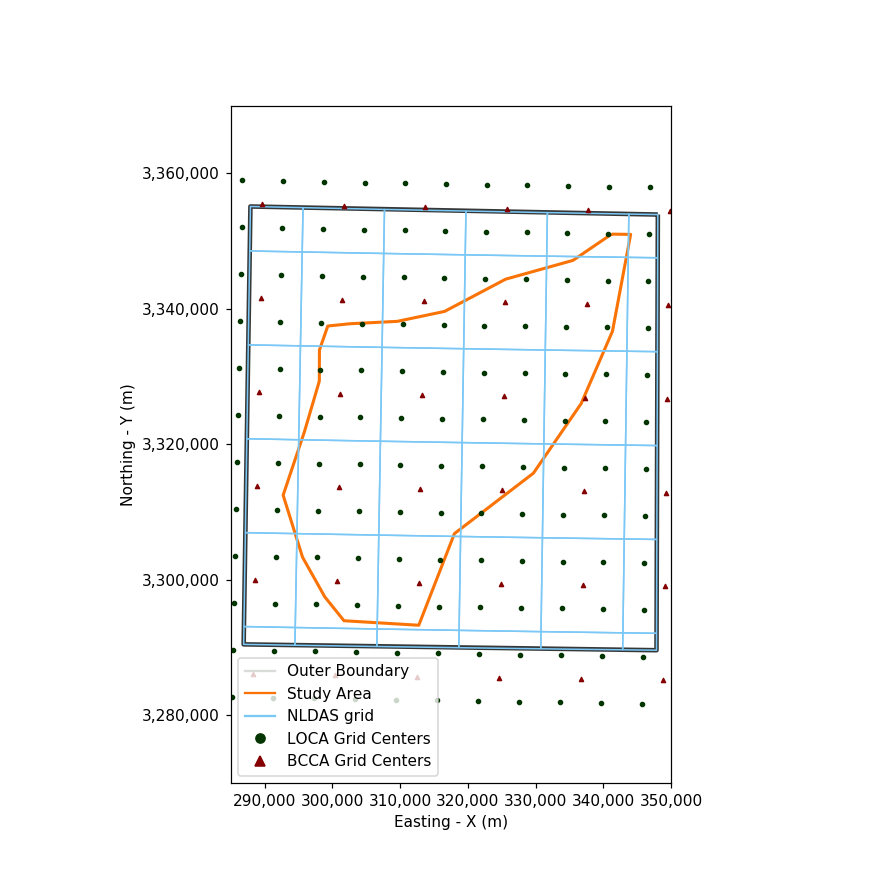

In [80]:
Fig1 = plt.figure()
Fig1.set_size_inches(8.0, 8.0)
ax11 = Fig1.add_subplot(111)
gpd_AOI.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, label="AOI" )
gpd_SBnd.plot( ax=ax11, facecolor='none', edgecolor='xkcd:dark grey', linewidth=3, label="Outer Bnd")
gpd_smNLDASU.plot( ax=ax11, facecolor='none', edgecolor='xkcd:lightblue', label="NLDAS" )
gpd_tPreU.plot( ax=ax11, marker='o', color='xkcd:dark green', markersize=7 )
gpd_tPreUBC.plot( ax=ax11, marker='^', color='xkcd:dark red', markersize=7 )
ob = Line2D( [0], [0], linestyle='-', color='xkcd:light grey' )
aoi = Line2D( [0], [0], linestyle='-', color='xkcd:orange' )
nlda = Line2D( [0], [0], linestyle='-', color='xkcd:lightblue' )
ncent = Line2D( [], [], linestyle='None', marker='o', color='xkcd:dark green')
bcent = Line2D( [], [], linestyle='None', marker='^', color='xkcd:dark red' )
ax11.legend( (ob, aoi, nlda, ncent, bcent), ('Outer Boundary', 'Study Area', 'NLDAS grid', 
                                      'LOCA Grid Centers', 'BCCA Grid Centers'),
             loc='lower left')
ax11.set_xlim( ( 285000, 350000 ) )
ax11.set_ylim( ( 3270000, 3370000 ) )
ax11.set_xlabel('Easting - X (m)')
ax11.set_ylabel('Northing - Y (m)')
ax11.yaxis.set_major_formatter( matplotlib.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( matplotlib.ticker.StrMethodFormatter( "{x:,.0f}" ) )

In [81]:
MasterGridDF = pd.concat( [updMetaDF, updMetaDFBC], ignore_index=True )

In [82]:
display( HTML( MasterGridDF.to_html() ) )

,Row,Col,Longitude,Lattitude,DS_Method,DS_Resolution,utm_x,utm_y
0,0,0,-101.34375,29.65625,LOCA,1/16th degree,273143.21875,3282992.75
1,0,1,-101.28125,29.65625,LOCA,1/16th degree,279194.40625,3282871.75
2,0,2,-101.21875,29.65625,LOCA,1/16th degree,285245.43750,3282754.25
3,0,3,-101.15625,29.65625,LOCA,1/16th degree,291296.34375,3282639.75
4,0,4,-101.09375,29.65625,LOCA,1/16th degree,297347.15625,3282528.75
5,0,5,-101.03125,29.65625,LOCA,1/16th degree,303397.81250,3282420.75
6,0,6,-100.96875,29.65625,LOCA,1/16th degree,309448.34375,3282316.25
7,0,7,-100.90625,29.65625,LOCA,1/16th degree,315498.78125,3282215.00
8,0,8,-100.84375,29.65625,LOCA,1/16th degree,321549.09375,3282117.00
9,0,9,-100.78125,29.65625,LOCA,1/16th degree,327599.28125,3282022.25


In [ ]:
#engine = sqlalchemy.create_engine( DBAD.DSN_STRING )

In [ ]:
# metadata only needs to be added one time to the database so can keep this commented out unless
#   need to delete that table for some reason.
#MasterGridDF.to_sql( DBAD.CMIP5_PTMETA, engine, schema=DBAD.CMIP5_SCHEMA, if_exists='append', 
#                     index=False )

Output two shapefiles - one for each of our grid centers

In [ ]:
#OutFileName = "LOCA5_116_GridPts.shp"
#OutFP = os.path.normpath( os.path.join( WORK_DIR, OutFileName ) )
#gpd_tPreU.to_file( OutFP, driver='ESRI Shapefile' )

In [ ]:
#OutFileName = "BCCA5_18_GridPts.shp"
#OutFP = os.path.normpath( os.path.join( WORK_DIR, OutFileName ) )
#gpd_tPreUBC.to_file( OutFP, driver='ESRI Shapefile' )

Now look through the precipitation values and find some nonzero ones to check.

In [83]:
tPrecip[0, 1, :, :].max(), tPrecip[0, 1, :, :].min()

(1.1405286, 0.0)

In [84]:
tPrecip[0, 1, :, :]

array([[0.5350299 , 0.5595213 , 0.38214484, 0.49479818, 0.50891477,
        0.55312026, 0.55613875, 0.5401182 , 0.530326  , 0.5441523 ,
        0.8714036 , 0.9204176 , 1.0248444 , 1.0554636 ],
       [0.44969177, 0.41366675, 0.42278203, 0.3554095 , 0.3907747 ,
        0.42220384, 0.46455756, 0.5057349 , 0.51933503, 0.5159361 ,
        0.54153347, 0.8586413 , 0.9095963 , 0.91694355],
       [0.32819736, 0.31860852, 0.319665  , 0.32716596, 0.33778128,
        0.31654862, 0.364888  , 0.42111653, 0.4298802 , 0.45831686,
        0.5019587 , 0.53282845, 0.87454593, 0.8268379 ],
       [0.2835649 , 0.24463254, 0.21822232, 0.21052408, 0.21352205,
        0.2845743 , 0.30000672, 0.34918943, 0.3967055 , 0.42626843,
        0.4744604 , 0.5197041 , 0.55757415, 0.7621668 ],
       [0.23529668, 0.18446067, 0.09187768, 0.08960524, 0.09431051,
        0.1765009 , 0.25998503, 0.48735258, 0.33293113, 0.38542503,
        0.4675357 , 0.47561234, 0.34538504, 0.37387243],
       [0.26189637, 0.1497546 , 0.0

In [85]:
Check1List = list()
for iI in range(NumRows):
    for jJ in range(NumCols):
        Check1List.append( tPrecip[0, 1, iI, jJ] )
    # end of inner for
# end of outer for
Check1 = np.array( Check1List, dtype=np.float32 )

In [86]:
Check2 = tPrecip[0, 1, :, :].flatten()

In [87]:
updMetaDF["Check1"] = Check1
updMetaDF["Check2"] = Check2

In [88]:
display( HTML( updMetaDF.to_html() ) )

,Row,Col,Longitude,Lattitude,DS_Method,DS_Resolution,utm_x,utm_y,Check1,Check2
1,0,0,-101.34375,29.65625,LOCA,1/16th degree,273143.21875,3282992.75,0.535030,0.535030
2,0,1,-101.28125,29.65625,LOCA,1/16th degree,279194.40625,3282871.75,0.559521,0.559521
3,0,2,-101.21875,29.65625,LOCA,1/16th degree,285245.43750,3282754.25,0.382145,0.382145
4,0,3,-101.15625,29.65625,LOCA,1/16th degree,291296.34375,3282639.75,0.494798,0.494798
5,0,4,-101.09375,29.65625,LOCA,1/16th degree,297347.15625,3282528.75,0.508915,0.508915
6,0,5,-101.03125,29.65625,LOCA,1/16th degree,303397.81250,3282420.75,0.553120,0.553120
7,0,6,-100.96875,29.65625,LOCA,1/16th degree,309448.34375,3282316.25,0.556139,0.556139
8,0,7,-100.90625,29.65625,LOCA,1/16th degree,315498.78125,3282215.00,0.540118,0.540118
9,0,8,-100.84375,29.65625,LOCA,1/16th degree,321549.09375,3282117.00,0.530326,0.530326
10,0,9,-100.78125,29.65625,LOCA,1/16th degree,327599.28125,3282022.25,0.544152,0.544152


In [89]:
testBC.close()
testLC.close()

This means that we can use flatten and go through a time step by a time to build our arrays

Look at the structure of the data or observations archives

In [90]:
iI = 0
CurDir = ControlDF.at[(iI + 1), 'Label']
CurDir

'R1LOCA50t80'

In [91]:
pFile = "%s_%s.%s" % (DATA_ROOT, PRECIP_ROOT, NC_EXT)
tmaxFile = "%s_%s.%s" % (DATA_ROOT, TMAX_ROOT, NC_EXT)
tminFile = "%s_%s.%s" % (DATA_ROOT, TMIN_ROOT, NC_EXT)

In [92]:
DataFile = os.path.normpath( os.path.join( WORK_DIR, CurDir, L5OBS_FOLDER, pFile ) )

In [93]:
testDATA = xr.open_dataset( DataFile )

In [94]:
testDATA

<xarray.Dataset>
Dimensions:  (lat: 12, lon: 14, projection: 1, time: 11323)
Coordinates:
  * lon      (lon) float64 -101.3 -101.3 -101.2 -101.2 ... -100.7 -100.6 -100.5
  * lat      (lat) float64 29.66 29.72 29.78 29.84 ... 30.16 30.22 30.28 30.34
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 1980-12-31
Dimensions without coordinates: projection
Data variables:
    pr       (projection, time, lat, lon) float32 ...
Attributes:
    CDI:                       Climate Data Interface version 1.6.4 (http://c...
    Conventions:               CF-1.4
    history:                   Fri Oct 10 17:54:37 2014: cdo ifthenelse /Volu...
    nco_openmp_thread_number:  1
    NCO:                       4.4.5
    CDO:                       Climate Data Operators version 1.6.4 (http://c...
    Projections:               Livneh2014_observed, 

In [95]:
prView = testDATA['pr']

In [96]:
exData = prView.data
exData.shape

(1, 11323, 12, 14)

The structure is similar to the model results so can use the same grid and approach.

Folders that are all in the future do not have a data directory which makes sense. In the examination of the data set below, data/observations end on 12/31/2005.

In [97]:
testDATA.close()

In [98]:
#tmxFile = os.path.normpath( os.path.join( WORK_DIR, CurDir, L5OBS_FOLDER, tmaxFile ) )
#tmnFile = os.path.normpath( os.path.join( WORK_DIR, CurDir, L5OBS_FOLDER, tminFile ) )

In [99]:
#dtmax =  xr.open_dataset( tmxFile )

In [100]:
#dtmax

In [101]:
#dtmax.close()

In [102]:
#dtmin =  xr.open_dataset( tmnFile )

In [103]:
#dtmin

In [104]:
#dtmin.close()

In [105]:
iI = 1
CurDir = ControlDF.at[(iI + 1), 'Label']
CurDir

'R2LOCA81t10'

In [106]:
DataFile = os.path.normpath( os.path.join( WORK_DIR, CurDir, L5OBS_FOLDER, pFile ) )

In [107]:
testDATA = xr.open_dataset( DataFile )

In [108]:
testDATA

<xarray.Dataset>
Dimensions:  (lat: 12, lon: 14, projection: 1, time: 9131)
Coordinates:
  * lon      (lon) float64 -101.3 -101.3 -101.2 -101.2 ... -100.7 -100.6 -100.5
  * lat      (lat) float64 29.66 29.72 29.78 29.84 ... 30.16 30.22 30.28 30.34
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2005-12-31
Dimensions without coordinates: projection
Data variables:
    pr       (projection, time, lat, lon) float32 ...
Attributes:
    CDI:                       Climate Data Interface version 1.6.4 (http://c...
    Conventions:               CF-1.4
    history:                   Sat Oct 11 06:04:31 2014: cdo ifthenelse /Volu...
    nco_openmp_thread_number:  1
    NCO:                       4.4.5
    CDO:                       Climate Data Operators version 1.6.4 (http://c...
    Projections:               Livneh2014_observed, 

In [109]:
da = testDATA['pr']

In [110]:
cTO = da.time
cTS = cTO.data

In [111]:
cTS.shape

(9131,)

In [112]:
cTS[9120:]

array(['2005-12-21T00:00:00.000000000', '2005-12-22T00:00:00.000000000',
       '2005-12-23T00:00:00.000000000', '2005-12-24T00:00:00.000000000',
       '2005-12-25T00:00:00.000000000', '2005-12-26T00:00:00.000000000',
       '2005-12-27T00:00:00.000000000', '2005-12-28T00:00:00.000000000',
       '2005-12-29T00:00:00.000000000', '2005-12-30T00:00:00.000000000',
       '2005-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [113]:
testDATA.close()

## Acquire Time Series Data from the Archives

First we want to fill in our complete run table so that we can use a foreign key constraint on the time series table.

In [114]:
NumDirs = len( ControlDF )
NumDirs

15

In [115]:
RunTableDFList = list()
PrevCount = 0
for iI in range(NumDirs):
    # get the current directory in the download structure
    CurDir = ControlDF.at[(iI + 1), 'Label']
    cWD = os.path.normpath( os.path.join( IN_DIR, CurDir ) )
    if iI < 10:
        cLocaDir = os.path.normpath( os.path.join( cWD, LOCA5_FOLDER ) )
    else:
        cLocaDir = os.path.normpath( os.path.join( cWD, BCCA5_FOLDER ) )
    ModelsFile = os.path.normpath( os.path.join( cLocaDir, MODS_FILE ) )
    # read in the listing of models in this result collection
    cModDict = DBAD.processModelsFile( ModelsFile )
    cNumModels = len( cModDict )
    if ((iI == 0) or (iI == 5) or (iI == 10)):
        if (iI != 0):
            PrevCount = PrevCount + NumModels
        NumModels = cNumModels
        ModDict = cModDict
        MDKeys = sorted( ModDict.keys() )
        DSName = ControlDF.at[(iI + 1), 'Data Set']
    else:
        if NumModels != cNumModels:
            # then there is an issue
            print("Found %d models in %s. Expected %d models!!!" % 
                  (cNumModels, CurDir, NumModels))
            break
        # now test the keys
        cDKeys = sorted( cModDict.keys() )
        KeyMatch = all( x in MDKeys for x in cDKeys )
        if not KeyMatch:
            print("Different models found between two output intervals in "
                  "the same collection!!!")
            break
        # check that are identical
        AllMatch = all( ModDict.get(x) == cModDict.get(x) for x in MDKeys )
        if not AllMatch:
            print("The model ordering, runs, or scenarios do match within the "
                  "same results collection!!!")
            break
        # then see if are at a point to archive our runs
        if ((iI == 4) or (iI == 9) or (iI == 14)):
            DSNamesL = [ ModDict[x][0] for x in MDKeys ]
            RunNumbers = [ ModDict[x][1] for x in MDKeys ]
            ScenNames = [ ModDict[x][2] for x in MDKeys ]
            ScenIndex = [ x for x in MDKeys ]
            DataDict = { DBAD.FIELDN_SCIND : ScenIndex,
                         DBAD.FIELDN_INITC : RunNumbers,
                         DBAD.FIELDN_SCENID : ScenNames, 
                         DBAD.FIELDN_MODCOL : DSNamesL,
                       }
            cRunTableDF = pd.DataFrame( data=DataDict )
            RunTableDFList.append( cRunTableDF )
    # keep going and read in model results and data
# end of for loop

Make the master dataframe to use to populate our table.

In [116]:
MasterModelDF = pd.concat( RunTableDFList, ignore_index=True )

In [117]:
len( MasterModelDF ), PrevCount, PrevCount + NumModels

(196, 64, 196)

In [118]:
display( HTML( MasterModelDF.head().to_html() ) )

,Result_Ind,ICRunNum,Scenario_ID,CMIP5_Model
0,0,1,rcp45,access1-0
1,1,1,rcp45,access1-3
2,2,1,rcp45,bcc-csm1-1
3,3,1,rcp45,bcc-csm1-1-m
4,4,1,rcp45,canesm2


Now are ready to write to our table

In [ ]:
#engine = sqlalchemy.create_engine( DBAD.DSN_STRING )

In [ ]:
# metadata only needs to be added one time to the database so can keep this commented out unless
#   need to delete that table for some reason.
#MasterModelDF.to_sql( DBAD.CMIP5_MODMETA, engine, schema=DBAD.CMIP5_SCHEMA, if_exists='append', 
#                      index=False )

In [119]:
bNumRows, bNumCols, bNumNodes

(6, 7, 42)

In [120]:
NumRows, NumCols, NumNodes

(12, 14, 168)

Going through the entire data set and extracting to database tables is complicated by the number of models and number of grid cells. Both model simulations and grid nodes have their own metadata tables in the database. These tables have been pre-created and are represented in this notebook with the following two DataFrames.

- **MasterGridDF**
- **MasterModelDF**

A foreign key reference is used in the time series tables to tie each data point the correct location (i.e. grid node) and the correct model scenario. The foreign key refers to the corresponding metadata table primary key. Auto-numbered primary keys are used for these two tables so that the index value for the DataFrames can be used if it is increased by one to reflect the transition from 0-based indexing (in the DataFrames) to 1-based indexing (in the SQL Server database).

Offsets are tracked and used to address the different model/scenario collections and the different grid layouts between LOCA and BCCA downscaling methods. The offset tracking variables are listed below.

- GridPKRef: tracks the key or index value in **MasterGridDF** where the current grid defintion begins. LOCA grid begins at 0 and BCCA grid begins at 168.
- PrevCount: tracks the starting point for the current model/scenario dictionary in **MasterModelDF**. Any particular model/scenario index, primary key reference is obtained using the the current dataset index plus PrevCount. 

The two calculations below represent the foreign keys for time series tables for the LOCA and BCCA grids, respectively.

In [135]:
L5GridKeys = np.zeros( NumNodes, dtype=np.int16 )
for iI in range(NumRows):
    for jJ in range(NumCols):
        cNode = ( iI * NumCols ) + jJ
        L5GridKeys[cNode] = cNode + 1
    # end of inner
# end of outer
L5GridKeys

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168],
      dtype=int16)

In [136]:
B5GridKeys = np.zeros( bNumNodes, dtype=np.int16 )
for iI in range(bNumRows):
    for jJ in range(bNumCols):
        cNode = ( iI * bNumCols ) + jJ
        B5GridKeys[cNode] = cNode + NumNodes + 1
    # end of inner
# end of outer
B5GridKeys

array([169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
       182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
       195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,
       208, 209, 210], dtype=int16)

Create a list of runs that need to have data or observations extracted; this list should be 0-indexed.

In [137]:
ZIDataRuns = [ 0, 1, 10, 11 ]

Setup the connection for the database

In [138]:
engine = sqlalchemy.create_engine( DBAD.DSN_STRING )

Now read in all of the time series values and transfer them to the database

In [139]:
#print("%s" % (dt.datetime.now()).strftime("%m/%d/%Y %H:%M:%S"))
RunTableDFList = list()
# to do it this way need to update PrevCount too
PrevCount = 0     # 0 - 4
for iI in range(NumDirs):
    # get the current directory in the download structure
    CurDir = ControlDF.at[(iI + 1), 'Label']
    print("Working on %s" % CurDir)
    print("    %s" % (dt.datetime.now()).strftime("%m/%d/%Y %H:%M:%S"))
    cWD = os.path.normpath( os.path.join( IN_DIR, CurDir ) )
    if iI < 10:
        cResDir = os.path.normpath( os.path.join( cWD, LOCA5_FOLDER ) )
        cDataDir = os.path.normpath( os.path.join( cWD, L5OBS_FOLDER ) )
        GridPKeys = L5GridKeys
        GridCnt = NumNodes
    else:
        cResDir = os.path.normpath( os.path.join( cWD, BCCA5_FOLDER ) )
        cDataDir = os.path.normpath( os.path.join( cWD, B5OBS_FOLDER ) )
        GridPKeys = B5GridKeys
        GridCnt = bNumNodes
    ModelsFile = os.path.normpath( os.path.join( cResDir, MODS_FILE ) )
    # read in the listing of models in this result collection
    cModDict = DBAD.processModelsFile( ModelsFile )
    cNumModels = len( cModDict )
    if ((iI == 0) or (iI == 5) or (iI == 10)):
        if (iI == 10):
            PrevCount = PrevCount + NumModels
        NumModels = cNumModels
        ModDict = cModDict
        MDKeys = sorted( ModDict.keys() )
    # start with precip results
    pFile = "%s_%s.%s" % (DATA_ROOT, PRECIP_ROOT, NC_EXT)
    rInFile = os.path.normpath( os.path.join( cResDir, pFile ) )
    ncFullPrecip = xr.open_dataset( rInFile )
    # the following is our top level reference to the data structure
    cResStruct = ncFullPrecip['pr']
    # get out the time series -- this is index == 1, with zero indexing
    dtDA = cResStruct.time
    # set it up to be UTC for PRISM agreement; this is not really the case
    cpdTSeries = pd.to_datetime( dtDA.data, utc=True )
    # specified at mid day or 12 for the middle of the day, want to 
    # use constant over next
    ConONextTS = cpdTSeries - pd.Timedelta(hours=12)
    NumTimes = len( ConONextTS )
    # now get the full precip matrix (model, TS, Row, Column)
    cPrecip = cResStruct.data
    print("    Working on simulated precip")
    # now need to go through by models, then by times and make a DataFrame 
    #   to write to the database
    for mM in range(NumModels):
        # get the model metadata primary key/current foreign key
        cMMPK = mM + PrevCount + 1
        mmPKeys = cMMPK * np.ones( GridCnt, dtype=np.int16 )
        TimeDFList = list()
        for tT in range(NumTimes):
            cDTimer = ConONextTS[tT]
            cDTimeL = [ cDTimer for x in range( GridCnt ) ]
            cValArray = cPrecip[mM, tT, :, :].flatten()
            DataDict = { DBAD.FIELDN_MMPK : mmPKeys,
                         DBAD.FIELDN_GNPK : GridPKeys,
                         DBAD.FIELDN_DT : cDTimeL,
                         DBAD.FIELDN_PVAL : cValArray,
                       }
            cDF = pd.DataFrame( data=DataDict )
            TimeDFList.append( cDF )
        # end of for
        # concatenate our lists for each time interval
        cModelDF = pd.concat( TimeDFList, ignore_index=True )
        # now fill NaN
        cModelDF[[DBAD.FIELDN_PVAL]] = cModelDF[[DBAD.FIELDN_PVAL]].fillna( value=NO_DATA  )
        # write to our database table
        cModelDF.to_sql( DBAD.CMIP5_PRECIP, engine, schema=DBAD.CMIP5_SCHEMA, 
                         if_exists='append', index=False )
    # close the precip file/structure
    ncFullPrecip.close()
    # now do modeled daily maximum temp (tasmax)
    tFile = "%s_%s.%s" % (DATA_ROOT, TMAX_ROOT, NC_EXT)
    rInFile = os.path.normpath( os.path.join( cResDir, tFile ) )
    ncFullTMax = xr.open_dataset( rInFile )
    # the following is our top level reference to the data structure
    cResStruct = ncFullTMax['tasmax']
    # get out the time series -- this is index == 1, with zero indexing
    dtDA = cResStruct.time
    # set it up to be UTC for PRISM agreement; this is not really the case
    cpdTSeries = pd.to_datetime( dtDA.data, utc=True )
    # specified at mid day or 12 for the middle of the day, want to 
    # use constant over next
    ConONextTS = cpdTSeries - pd.Timedelta(hours=12)
    NumTimes = len( ConONextTS )
    # now get the full matrix (model, TS, Row, Column)
    cTMax = cResStruct.data
    print("    Working on simulated tmax")
    # now need to go through by models, then by times and make a DataFrame 
    #   to write to the database
    for mM in range(NumModels):
        # get the model metadata primary key/current foreign key
        cMMPK = mM + PrevCount + 1
        mmPKeys = cMMPK * np.ones( GridCnt, dtype=np.int16 )
        TimeDFList = list()
        for tT in range(NumTimes):
            cDTimer = ConONextTS[tT]
            cDTimeL = [ cDTimer for x in range( GridCnt ) ]
            cValArray = cTMax[mM, tT, :, :].flatten()
            DataDict = { DBAD.FIELDN_MMPK : mmPKeys,
                         DBAD.FIELDN_GNPK : GridPKeys,
                         DBAD.FIELDN_DT : cDTimeL,
                         DBAD.FIELDN_TMXVAL : cValArray,
                       }
            cDF = pd.DataFrame( data=DataDict )
            TimeDFList.append( cDF )
        # end of for
        # concatenate our lists for each time interval
        cModelDF = pd.concat( TimeDFList, ignore_index=True )
        # now fill NaN
        cModelDF[[DBAD.FIELDN_TMXVAL]] = cModelDF[[DBAD.FIELDN_TMXVAL]].fillna( value=NO_DATA  )
        # write to our database table
        cModelDF.to_sql( DBAD.CMIP5_TMAX, engine, schema=DBAD.CMIP5_SCHEMA, 
                         if_exists='append', index=False )
    # close the file/structure
    ncFullTMax.close()
    # now do modeled daily minimum temp (tasmin)
    tFile = "%s_%s.%s" % (DATA_ROOT, TMIN_ROOT, NC_EXT)
    rInFile = os.path.normpath( os.path.join( cResDir, tFile ) )
    ncFullTMin = xr.open_dataset( rInFile )
    # the following is our top level reference to the data structure
    cResStruct = ncFullTMin['tasmin']
    # get out the time series -- this is index == 1, with zero indexing
    dtDA = cResStruct.time
    # set it up to be UTC for PRISM agreement; this is not really the case
    cpdTSeries = pd.to_datetime( dtDA.data, utc=True )
    # specified at mid day or 12 for the middle of the day, want to 
    # use constant over next
    ConONextTS = cpdTSeries - pd.Timedelta(hours=12)
    NumTimes = len( ConONextTS )
    # now get the full matrix (model, TS, Row, Column)
    cTMin = cResStruct.data
    print("    Working on simulated tmin")
    # now need to go through by models, then by times and make a DataFrame 
    #   to write to the database
    for mM in range(NumModels):
        # get the model metadata primary key/current foreign key
        cMMPK = mM + PrevCount + 1
        mmPKeys = cMMPK * np.ones( GridCnt, dtype=np.int16 )
        TimeDFList = list()
        for tT in range(NumTimes):
            cDTimer = ConONextTS[tT]
            cDTimeL = [ cDTimer for x in range( GridCnt ) ]
            cValArray = cTMin[mM, tT, :, :].flatten()
            DataDict = { DBAD.FIELDN_MMPK : mmPKeys,
                         DBAD.FIELDN_GNPK : GridPKeys,
                         DBAD.FIELDN_DT : cDTimeL,
                         DBAD.FIELDN_TMNVAL : cValArray,
                       }
            cDF = pd.DataFrame( data=DataDict )
            TimeDFList.append( cDF )
        # end of for
        # concatenate our lists for each time interval
        cModelDF = pd.concat( TimeDFList, ignore_index=True )
        # now fill NaN
        cModelDF[[DBAD.FIELDN_TMNVAL]] = cModelDF[[DBAD.FIELDN_TMNVAL]].fillna( value=NO_DATA  )
        # write to our database table
        cModelDF.to_sql( DBAD.CMIP5_TMIN, engine, schema=DBAD.CMIP5_SCHEMA, 
                         if_exists='append', index=False )
    # close the file/structure
    ncFullTMin.close()
    # see if need to do the observations
    if not (iI in ZIDataRuns):
        continue
    # if made it here then need to do the data or observation extractions
    pFile = "%s_%s.%s" % (DATA_ROOT, PRECIP_ROOT, NC_EXT)
    rInFile = os.path.normpath( os.path.join( cDataDir, pFile ) )
    ncFullPrecip = xr.open_dataset( rInFile )
    # the following is our top level reference to the data structure
    cResStruct = ncFullPrecip['pr']
    # get out the time series -- this is index == 1, with zero indexing
    dtDA = cResStruct.time
    # set it up to be UTC for PRISM agreement; this is not really the case
    cpdTSeries = pd.to_datetime( dtDA.data, utc=True )
    # specified at mid day or 12 for the middle of the day, want to 
    # use constant over next
    ConONextTS = cpdTSeries - pd.Timedelta(hours=12)
    NumTimes = len( ConONextTS )
    # now get the full precip matrix (1, TS, Row, Column)
    cPrecip = cResStruct.data
    print("    Working on observed precip")
    # no models so just times and grids
    TimeDFList = list()
    for tT in range(NumTimes):
        cDTimer = ConONextTS[tT]
        cDTimeL = [ cDTimer for x in range( GridCnt ) ]
        cValArray = cPrecip[0, tT, :, :].flatten()
        DataDict = { DBAD.FIELDN_GNPK : GridPKeys,
                     DBAD.FIELDN_DT : cDTimeL,
                     DBAD.FIELDN_PVAL : cValArray,
                   }
        cDF = pd.DataFrame( data=DataDict )
        TimeDFList.append( cDF )
    # end of for
    # concatenate our lists for each time interval
    cModelDF = pd.concat( TimeDFList, ignore_index=True )
    # write to our database table
    cModelDF.to_sql( DBAD.CMIP5_OBSPRE, engine, schema=DBAD.CMIP5_SCHEMA, 
                     if_exists='append', index=False )
    # close the precip file/structure
    ncFullPrecip.close()
    # now do modeled daily maximum temp (tasmax)
    tFile = "%s_%s.%s" % (DATA_ROOT, TMAX_ROOT, NC_EXT)
    rInFile = os.path.normpath( os.path.join( cDataDir, tFile ) )
    ncFullTMax = xr.open_dataset( rInFile )
    # the following is our top level reference to the data structure
    cResStruct = ncFullTMax['tasmax']
    # get out the time series -- this is index == 1, with zero indexing
    dtDA = cResStruct.time
    # set it up to be UTC for PRISM agreement; this is not really the case
    cpdTSeries = pd.to_datetime( dtDA.data, utc=True )
    # specified at mid day or 12 for the middle of the day, want to 
    # use constant over next
    ConONextTS = cpdTSeries - pd.Timedelta(hours=12)
    NumTimes = len( ConONextTS )
    # now get the full matrix (1, TS, Row, Column)
    cTMax = cResStruct.data
    print("    Working on observed tmax")
    # now go through by time and grid
    TimeDFList = list()
    for tT in range(NumTimes):
        cDTimer = ConONextTS[tT]
        cDTimeL = [ cDTimer for x in range( GridCnt ) ]
        cValArray = cTMax[0, tT, :, :].flatten()
        DataDict = { DBAD.FIELDN_GNPK : GridPKeys,
                     DBAD.FIELDN_DT : cDTimeL,
                     DBAD.FIELDN_TMXVAL : cValArray,
                   }
        cDF = pd.DataFrame( data=DataDict )
        TimeDFList.append( cDF )
    # end of for
    # concatenate our lists for each time interval
    cModelDF = pd.concat( TimeDFList, ignore_index=True )
    # write to our database table
    cModelDF.to_sql( DBAD.CMIP5_OBSTMAX, engine, schema=DBAD.CMIP5_SCHEMA, 
                     if_exists='append', index=False )
    # close the file/structure
    ncFullTMax.close()
    # now do modeled daily minimum temp (tasmin)
    tFile = "%s_%s.%s" % (DATA_ROOT, TMIN_ROOT, NC_EXT)
    rInFile = os.path.normpath( os.path.join( cDataDir, tFile ) )
    ncFullTMin = xr.open_dataset( rInFile )
    # the following is our top level reference to the data structure
    cResStruct = ncFullTMin['tasmin']
    # get out the time series -- this is index == 1, with zero indexing
    dtDA = cResStruct.time
    # set it up to be UTC for PRISM agreement; this is not really the case
    cpdTSeries = pd.to_datetime( dtDA.data, utc=True )
    # specified at mid day or 12 for the middle of the day, want to 
    # use constant over next
    ConONextTS = cpdTSeries - pd.Timedelta(hours=12)
    NumTimes = len( ConONextTS )
    # now get the full matrix (model, TS, Row, Column)
    cTMin = cResStruct.data
    print("    Working on observed tmin")
    # now go through by time and grid
    TimeDFList = list()
    for tT in range(NumTimes):
        cDTimer = ConONextTS[tT]
        cDTimeL = [ cDTimer for x in range( GridCnt ) ]
        cValArray = cTMin[0, tT, :, :].flatten()
        DataDict = { DBAD.FIELDN_GNPK : GridPKeys,
                     DBAD.FIELDN_DT : cDTimeL,
                     DBAD.FIELDN_TMNVAL : cValArray,
                   }
        cDF = pd.DataFrame( data=DataDict )
        TimeDFList.append( cDF )
    # end of for
    # concatenate our lists for each time interval
    cModelDF = pd.concat( TimeDFList, ignore_index=True )
    # write to our database table
    cModelDF.to_sql( DBAD.CMIP5_OBSTMIN, engine, schema=DBAD.CMIP5_SCHEMA, 
                     if_exists='append', index=False )
    # close the file/structure
    ncFullTMin.close()
    print("    end of folder/directory")
    print("    %s" % (dt.datetime.now()).strftime("%m/%d/%Y %H:%M:%S"))
# end of download for
#print("%s" % (dt.datetime.now()).strftime("%m/%d/%Y %H:%M:%S"))

Working on R10LOCA71t99
    07/17/2019 18:43:53
    Working on simulated precip
    Working on simulated tmax
    Working on simulated tmin
Working on R11BCCA50t80
    07/18/2019 01:06:42
    Working on simulated precip
    Working on simulated tmax
    Working on simulated tmin
    Working on observed precip
    Working on observed tmax
    Working on observed tmin
    end of folder/directory
    07/18/2019 08:53:03
Working on R12BCCA81t10
    07/18/2019 08:53:03
    Working on simulated precip
    Working on simulated tmax
    Working on simulated tmin
    Working on observed precip
    Working on observed tmax
    Working on observed tmin
    end of folder/directory
    07/18/2019 16:40:11
Working on R13BCCA11t40
    07/18/2019 16:40:11
    Working on simulated precip
    Working on simulated tmax
    Working on simulated tmin
Working on R14BCCA41t70
    07/19/2019 00:17:27
    Working on simulated precip
    Working on simulated tmax
    Working on simulated tmin
Working on R15BCCA

In [140]:
mM

131

In [141]:
NumModels

132

In [128]:
ModelsFile

'\\\\augustine.space.swri.edu\\jdrive\\Groundwater\\R8937_Stochastic_CC_Recharge\\Data\\CMIP5\\R10LOCA71t99\\loca5\\Projections5.txt'